# Election Data Project - Polls and Donors

In this Data Project we will be looking at data from the 2012 election.

In this project we will analyze two datasets. The first data set will be the results of political polls. We will analyze this aggregated poll data and answer some questions:

    1.) Who was being polled and what was their party affiliation?
    2.) Did the poll results favor Romney or Obama?
    3.) How do undecided voters effect the poll?
    4.) Can we account for the undecided voters?
    5.) How did voter sentiment change over time?
    6.) Can we see an effect in the polls from the debates?

We'll discuss the second data set later on!

---
#### This notebook was build in Python3 while doing the course exercise. The original noteboook is in Python2.

##### Since the original course publication some of the libraries have seen their behaviour modifed, especially Searborn. Throughout the notebook I've tried to highlight where the code differs from the original in order to produce the same outputs. When the libraries do not have a similar output now, I tried to use the next best options available.
---

Let's go ahead and start with our standard imports:

In [65]:
# For data
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

# For visualization
# NOTE: you'll notice that in this notebook the charts will be more "colorful" than the ones
#        shown in the original notebook. This is due to matplotlib (either used directly or from
#        pandas) has an updated default style, which I decided not to change for this exercise.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# NOTE: We don't need this as we're working on Python 3, while the original notebook was in Python 2
# from __future__ import division

The data for the polls will be obtained from HuffPost Pollster. You can check their website [here](http://elections.huffingtonpost.com/pollster). There are some pretty awesome politcal data stes to play with there so I encourage you to go and mess around with it yourself after completing this project.

We're going to use the requests module to import some data from the web. For more information on requests, check out the documentation [here](http://docs.python-requests.org/en/latest/).

We will also be using StringIO to work with csv data we get from HuffPost. StringIO provides a convenient means of working with text in memory using the file 
API, find out more about it [here](http://pymotw.com/2/StringIO/) 

Please note that this is changed from the original project, which was built for Python 2. The StringIO was moved to the io package.

In [11]:
# Use to grab data from the web(HTTP capabilities)
import requests

# We'll also use StringIO to work with the csv file, the DataFrame will require a .read() method
# NOTE: StringIO is now in the io package
from io import StringIO

In [12]:
# This is the url link for the poll data in csv form
url = "http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv"

# Use requests to get the information in text form
source = requests.get(url).text

# Use StringIO to avoid an IO error with pandas
poll_data = StringIO(source) 

In [13]:
# Set poll data as pandas DataFrame
poll_df = pd.read_csv(poll_data)

# Let's get a glimpse at the data
poll_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 17 columns):
Pollster                  586 non-null object
Start Date                586 non-null object
End Date                  586 non-null object
Entry Date/Time (ET)      586 non-null object
Number of Observations    564 non-null float64
Population                586 non-null object
Mode                      586 non-null object
Obama                     586 non-null float64
Romney                    586 non-null float64
Undecided                 423 non-null float64
Other                     202 non-null float64
Pollster URL              586 non-null object
Source URL                584 non-null object
Partisan                  586 non-null object
Affiliation               586 non-null object
Question Text             0 non-null float64
Question Iteration        586 non-null int64
dtypes: float64(6), int64(1), object(10)
memory usage: 77.9+ KB


In [14]:
# preview the DataFrame
poll_df.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1
3,IBD/TIPP,2012-11-03,2012-11-05,2012-11-06T08:51:48Z,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,http://elections.huffingtonpost.com/pollster/p...,http://news.investors.com/special-report/50841...,Nonpartisan,None,NaN,1
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06T08:47:50Z,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1


#### NOTE: When compared with the original data project, the most current data set has a few more columns and a few less records. Nevertheless, seems to be pretty similar to the data shown in the original notebook, containing the same information and structure. In some data operations below I will need to do additional operations in order to produce the same outputs. The overall results and conclusions are the same though.

Let's go ahead and get a quick visualization overview of the affiliation for the pools.

In [15]:
# NOTE: This piece is a bit different from the original course notebook.
#       I'll be explicitly converting some of the columns to the category data type so that those columns show ordered in
#        the graphics output. Without this, the values in the graphics is just taken from the order it appears in the data.
#       The other option would be to use the "order" arguments in the functions to indicate the sorting we want.
#       Also, throughout the notebook, each time I create a new column, we will convert that column to categorical if it's
#        used in the graphics
poll_df.Affiliation = pd.Categorical(poll_df.Affiliation)
poll_df.Population = pd.Categorical(poll_df.Population)

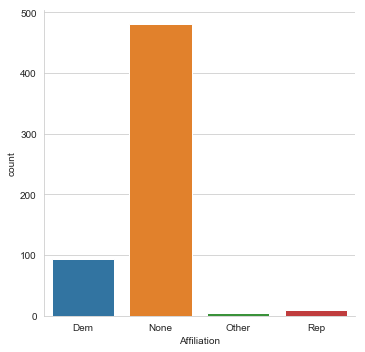

In [16]:
# Catplot the affiliation
# NOTE: The original notebook uses the factorplot method that is deprecated. We must use catplot instead, which
#        produces a more colorful output when compared with the original notebook.
sns.catplot(x="Affiliation", data=poll_df, kind="count")

Looks like we are overall relatively neutral, but still leaning towards Democratic Affiliation, it would be good to keep this is mind. Let's see if sorting by the Population hue gives any further insigh into the data.

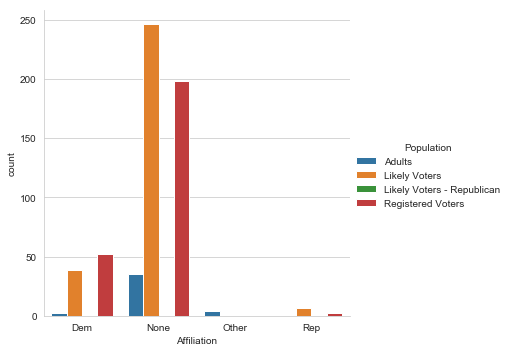

In [17]:
# catplot the Affiliation by Population
# NOTE: The original notebook uses the factorplot method that is deprecated. We must use catplot instead, which
#        produces a more colorful output when compared with the original notebook.
sns.catplot(x="Affiliation", data=poll_df, kind="count", hue="Population")

Looks like we a strong showing of likely voters and Registered Voters, so the poll data should hopefully be a good reflection on the populations polled. Let's take another quick overview of the DataFrame

In [18]:
# Let's look at the DataFrame again
poll_df.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1
3,IBD/TIPP,2012-11-03,2012-11-05,2012-11-06T08:51:48Z,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,http://elections.huffingtonpost.com/pollster/p...,http://news.investors.com/special-report/50841...,Nonpartisan,None,NaN,1
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06T08:47:50Z,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1


Let's go ahead and take a look at the averages for Obama, Romney, and the polled people who remained undecided.

In [19]:
# First we'll get the average
avg = pd.DataFrame(poll_df.mean())
avg

,0
Number of Observations,1296.679078
Obama,46.805461
Romney,44.614334
Undecided,6.550827
Other,3.376238
Question Text,NaN
Question Iteration,1.000000


In [20]:
# Drop some unnecessary rows
# NOTE: As the data I now get has a few more columns, I will also drop those in order to get the same output.
avg.drop(["Number of Observations", "Question Text", "Question Iteration", "Other"], axis=0, inplace=True)

# And after that we'll get the error and also get rid of unnecessary rows
std = pd.DataFrame(poll_df.std())
std.drop(["Number of Observations", "Question Text", "Question Iteration", "Other"], axis=0, inplace=True)

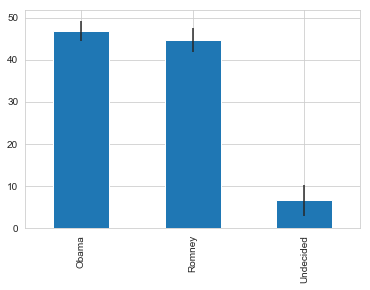

In [21]:
# now plot using pandas built-in plot, with kind = "bar" and yerr = std
avg.plot(yerr=std, kind="bar", legend=False)

It's interesting to see how close these pools seem to be, especially considering the undecided factor. Let's take a look at the numbers.

In [22]:
# Concatenate our Average and Std DataFrames
poll_avg = pd.concat([avg, std], axis=1)

# Rename the columns
poll_avg.columns = ["Average", "STD"]

# Show
poll_avg

,Average,STD
Obama,46.805461,2.422058
Romney,44.614334,2.906180
Undecided,6.550827,3.701754


Looks like the polls indicate it as a fairly close race, but what about the undecided voters? Most of them will likely vote for one of the candidates once the election occurs. If we assume we split the undecided voters evenly between the two candidates, the observed difference should be an unbaised estimate of the final difference.

In [23]:
# Again, another look at he DataFrame
poll_df.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1
3,IBD/TIPP,2012-11-03,2012-11-05,2012-11-06T08:51:48Z,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,http://elections.huffingtonpost.com/pollster/p...,http://news.investors.com/special-report/50841...,Nonpartisan,None,NaN,1
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06T08:47:50Z,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1


If we wanted to, we could also do a quick (and messy) time series analysis of the voter sentiment by plotting Obama/Romney favor versus the Poll End Dates. Let's take a look how we could quickly do that in pandas.

Note: the Time is in reverse chronological order. Also, keep in mind the multiple polls per end date.

c:\users\psilva\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


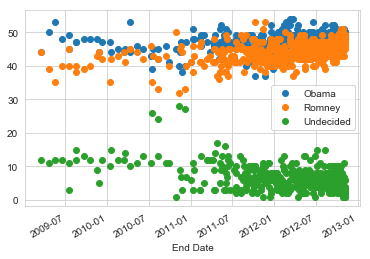

In [24]:
# Quick plot if sentiment in the polls versus time
# NOTE: The original notebook didn't for the conversion of the End Date column to a datetime column. However, in Python3 it
#       was not showing the labels in the x axis. As such, we converted the End Date column to a datetime and now it shows
#       the labels and has the nice side effect that also shows the date in ascending order. This also means that the
#       plot is a mirror of the original.
poll_df["End Date"] = poll_df["End Date"].astype("datetime64[ns]")
poll_df.plot(x="End Date", y=["Obama", "Romney", "Undecided"], marker="o", linestyle="")

While this may give you a quick idea, go ahead and try creating a new DataFrame or editing poll_df to make a better visualization of the above idea!

To lead you along the right path for plotting, we'll go ahead and answer another question related to plotting the sentiment versus time. Let's go ahead and plot out the difference between Obama and Romney and how it changes as time moves along. Remember from the last data project we used the datetime module to create timestamps, let's go ahead and use it now.

In [25]:
# For timestamps
from datetime import datetime

Now we'll define a new column in our poll_df DataFrame to take into account the difference between Romney and Obama in the polls.

In [26]:
# Create a new column for the difference between the two candidates
poll_df["Difference"] = (poll_df.Obama - poll_df.Romney) / 100
# Preview the new column
poll_df.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Other,Pollster URL,Source URL,Partisan,Affiliation,Question Text,Question Iteration,Difference
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06T08:40:26Z,1000.0,Likely Voters,Live Phone,47.0,47.0,6.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,NaN,1,0.00
1,YouGov/Economist,2012-11-03,2012-11-05,2012-11-26T15:31:23Z,740.0,Likely Voters,Internet,49.0,47.0,3.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://cdn.yougov.com/cumulus_uploads/document...,Nonpartisan,None,NaN,1,0.02
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06T09:22:02Z,872.0,Likely Voters,Automated Phone,48.0,48.0,4.0,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,NaN,1,0.00
3,IBD/TIPP,2012-11-03,2012-11-05,2012-11-06T08:51:48Z,712.0,Likely Voters,Live Phone,50.0,49.0,NaN,1.0,http://elections.huffingtonpost.com/pollster/p...,http://news.investors.com/special-report/50841...,Nonpartisan,None,NaN,1,0.01
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06T08:47:50Z,1500.0,Likely Voters,Automated Phone,48.0,49.0,NaN,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,NaN,1,-0.01


Keep in mind that the Difference column is Obama minus Romney, this a positive difference indicates a leaning towards Obama in the polls.

Now, let's go ahead and see if we can visualize how this sentiment changes over time. We will start by using groupby to group poll by their start date and then sorting that Start Date.

In [27]:
# Set as_index=False to keep the 0,1,2,... index. Then we'll take the mean of the polls on that day.
# NOTE: I will create a new DataFrame, while the original overrides the poll_df DataFrame
poll_diff = poll_df.groupby(["Start Date"], as_index=False).mean()

# Let's go ahead and see how this looks like
poll_diff.head()

,Start Date,Number of Observations,Obama,Romney,Undecided,Other,Question Text,Question Iteration,Difference
0,2009-03-13,1403.0,44.0,44.0,12.0,NaN,NaN,1,0.00
1,2009-04-17,686.0,50.0,39.0,11.0,NaN,NaN,1,0.11
2,2009-05-14,1000.0,53.0,35.0,12.0,NaN,NaN,1,0.18
3,2009-06-12,638.0,48.0,40.0,12.0,NaN,NaN,1,0.08
4,2009-07-15,577.0,49.0,40.0,11.0,NaN,NaN,1,0.09


Great! Now plotting the Difference versus time should be straight forward.

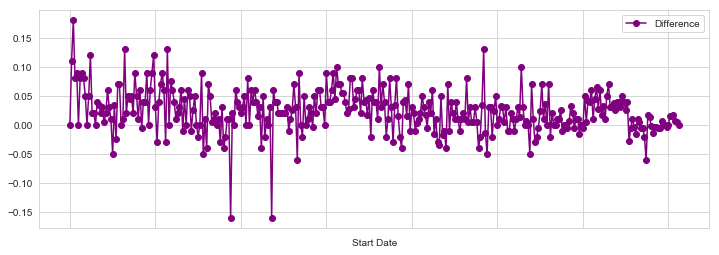

In [28]:
# Plotting the difference in polls between Obama and Romney
fig = poll_diff.plot("Start Date", "Difference", figsize=(12, 4), marker="o", linestyle="-", color="purple")

It would be very interesting to plot marker lines on the dates of the debates and see if there is any general insight to the poll results.

The debate dates were Oct 3rd, Oct 11, and Oct 22nd. Let's plot some lines as markers and then zoom in on the month of October.

In order to find where to set the x limits for the figure we need to find out where the index for the month of October in 2012 is. Here's a simple for loop to find that row. Note, the string format of the date makes this difficult to do without using a lambda expression or a map.

In [29]:
# Set row count and xlimit list
row_in = 0
xlimit = []

# Cycle through dates until 2012-10 is found, then print the row index
for date in poll_diff["Start Date"]:
    if date[0:7] == "2012-10":
        xlimit.append(row_in)
        row_in += 1
    else:
        row_in += 1

print(min(xlimit))
print(max(xlimit))

325
352


Great now we know where to set our x limits for the month of October in our figure.

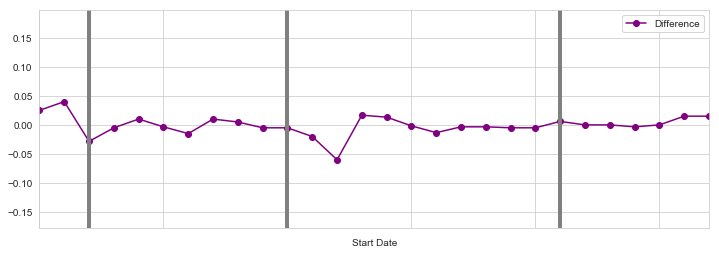

In [30]:
# Start with original figure
fig = poll_diff.plot('Start Date','Difference',figsize=(12,4),marker='o',linestyle='-',color='purple',xlim=(325,352))

# Now add the debate markers
plt.axvline(x=325+2, linewidth=4, color='grey')
plt.axvline(x=325+10, linewidth=4, color='grey')
plt.axvline(x=325+21, linewidth=4, color='grey')

Surprisingly, these pools reflect a dip for Obama after the second debate against Romney, even though memory serves that he performed much worse against Romney during the first debate.

For all these polls it is important to remeber how geographical location can effect the value of a poll in predicting the outcomes of a national election. 

# Donor Data Set

Let's go ahead and switch gears and take a look at a data set consisting of information on donations to the federal campaign.

This is going to be the biggest data set we've looked at so far. You can download it [here](https://www.dropbox.com/s/l29oppon2veaq4n/Election_Donor_Data.csv?dl=0) , then make sure to save it to the same folder your iPython Notebooks are in. (Note: I've put this inside a foleder named "data")

The questions we will be trying to answer while looking at this Data Set is:

    1.) How much was donated and what was the average donation?
    2.) How did the donations differ between candidates?
    3.) How did the donations differ between Democrats and Republicans?
    4.) What were the demographics of the donors?
    5.) Is there a pattern to donation amounts?
    

In [32]:
# Set the DataFrame as the csv file
donor_df = pd.read_csv("data/Election_Donor_Data.csv")

c:\users\psilva\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
# Get a quick overview
donor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 122.3+ MB


In [34]:
# Let's also take a glimpse
donor_df.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,3.68633e+08,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,7.24548e+08,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,7.19016e+08,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166


What might be interesting to do is to get a quick glimpse of the donation amounts, and the average donation amount. Let's go ahead and break down the data.

In [35]:
# Get a quick look at the various donation amounts
donor_df["contb_receipt_amt"].value_counts()

 100.00     178188
 50.00      137584
 25.00      110345
 250.00      91182
 500.00      57984
 2500.00     49005
 35.00       37237
 1000.00     36494
 10.00       33986
 200.00      27813
 20.00       17565
 15.00       16163
 150.00      14600
 75.00       13647
 201.20      11718
 30.00       11381
 300.00      11204
 20.12        9897
 5.00         9024
 40.00        5007
 2000.00      4128
 55.00        3760
 1500.00      3705
 3.00         3383
 60.00        3084
 400.00       3066
-2500.00      2727
 110.00       2554
 125.00       2520
 19.00        2474
             ...  
 174.80          1
 7.27            1
 1219.00         1
 1884.88         1
 162.25          1
 218.31          1
 78.62           1
 203.16          1
 53.11           1
 499.66          1
 19.53           1
 188.60          1
 47.10           1
 19.85           1
 28.83           1
 202.59          1
-5500.00         1
 9.25            1
 202.66          1
 1205.00         1
 80.73           1
 115.07     

8079 different amounts! That's quite a variation and the std.

In [36]:
# Get the mean donation
don_mean = donor_df["contb_receipt_amt"].mean()

# Get the std of the donation
don_std = donor_df["contb_receipt_amt"].std()

print("The average donation was %.2f with a std of %.2f" % (don_mean, don_std))

The average donation was 298.24 with a std of 3749.67


Wow! That's a huge standard deviation! Let's see if there are any large donations or other factors messing with the distribution of the donations.

In [38]:
# Let's make a Series from the DataFrame, use .copy() to avoid view errors
top_donor = donor_df["contb_receipt_amt"].copy()

# Now sort it
top_donor.sort_values(inplace=True)

# Then check the Series
top_donor

114604     -30800.00
226986     -25800.00
101356      -7500.00
398429      -5500.00
250737      -5455.00
33821       -5414.31
908565      -5115.00
456649      -5000.00
574657      -5000.00
30513       -5000.00
562267      -5000.00
30584       -5000.00
86268       -5000.00
708920      -5000.00
665887      -5000.00
708899      -5000.00
708929      -5000.00
21172       -5000.00
21168       -5000.00
21167       -5000.00
262328      -5000.00
946875      -5000.00
7361        -5000.00
416403      -5000.00
21164       -5000.00
707945      -5000.00
615101      -5000.00
7973        -5000.00
54430       -5000.00
54434       -5000.00
             ...    
708022      10000.00
708898      10000.00
710177      10000.00
876244      10000.00
709608      10000.00
708919      10000.00
709739      10000.00
91145       10000.00
708138      10000.00
993178      10000.00
709813      10000.00
710730      10000.00
708928      10000.00
709268      10000.00
99829       10000.00
90076       10000.00
709859      1

Looks like we have some negative values, as well as some huge donation amounts! The negative values are due to the FEC recording refunds as well as donations, let's go ahead and only look at the positive contribution amounts

In [39]:
# Get rid of the negative values
top_donor = top_donor[top_donor > 0]

# Sort the Series
top_donor.sort_values(inplace=True)

# Look at the top 10 most common donations value counts
top_donor.value_counts().head(10)

100.0     178188
50.0      137584
25.0      110345
250.0      91182
500.0      57984
2500.0     49005
35.0       37237
1000.0     36494
10.0       33986
200.0      27813
Name: contb_receipt_amt, dtype: int64

Here we can see that the top 10 most common donations ranged from 10 to 2500 dollars.

A quick question we could verify is if donations are usually made in round number amounts? (e.g. 10,20,50,100,500 etc.) We can quickly visualize this by making a histogram and checking for peaks at those values. Let's go ahead and do this for the most common amounts, up to 2500 dollars.

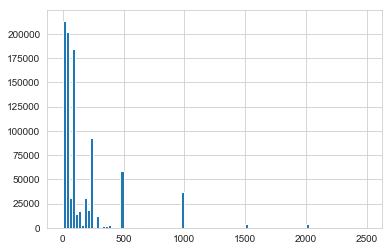

In [41]:
# Create a Series of common donations limited to 2500
com_don = top_donor[top_donor < 2500]

# Set a high number of bins to account for the non-round donations and check histogram for spikes
com_don.hist(bins=100)

Looks like our intuition was right, since we spikes at the round numbers.

Let's dive deeper into the data and see if we can seperate donations by Party, in order to do this we'll have to figure out a way of creating a new 'Party' column. We can do this by starting with the candidates and their affliliation. Now let's go ahead and get a list of candidates

In [42]:
# Grab the unique object from the candidate column
candidates = donor_df.cand_nm.unique()
# Show
candidates

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick',
       'Cain, Herman', 'Gingrich, Newt', 'McCotter, Thaddeus G',
       'Huntsman, Jon', 'Perry, Rick'], dtype=object)

Let's go ahead and seperate Obama from the Republican Candidates by adding a Party Affiliation column. We can do this by using map along a dictionary of party affiliations. Lecture 36 has a review of this topic.

In [43]:
# Dictionary of party affiliation
party_map = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

# Now map the party with the candidate
donor_df["Party"] = donor_df.cand_nm.map(party_map)

A quick note, we could have done this same operation manually using a for loop, however this operation would be much slower than using the map method.

In [44]:
'''
for i in xrange(0,len(donor_df)):
    if donor_df['cand_nm'][i] == 'Obama,Barack':
        donor_df['Party'][i] = 'Democrat'
    else:
        donor_df['Party'][i] = 'Republican'
'''

"\nfor i in xrange(0,len(donor_df)):\n    if donor_df['cand_nm'][i] == 'Obama,Barack':\n        donor_df['Party'][i] = 'Democrat'\n    else:\n        donor_df['Party'][i] = 'Republican'\n"

Let's look at our DataFrame and also make sure we clear refunds from the contribution amounts.

In [45]:
# Clear refunds
donor_df = donor_df[donor_df.contb_receipt_amt > 0]

# Preview the DataFrame
donor_df.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,Party
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.6601e+08,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,3.68633e+08,INFORMATION REQUESTED,INFORMATION REQUESTED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073,Republican
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,7.24548e+08,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073,Republican
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,7.19016e+08,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican


Let's start by aggregating the data by candidate. We'll take a quick look a the total amounts received by each candidate. First we will look a the total number of donations and then at the total amount.

In [46]:
# Groupby candidate and then display the total number of people who donated
donor_df.groupby("cand_nm")["contb_receipt_amt"].count()

cand_nm
Bachmann, Michelle                 13082
Cain, Herman                       20052
Gingrich, Newt                     46883
Huntsman, Jon                       4066
Johnson, Gary Earl                  1234
McCotter, Thaddeus G                  73
Obama, Barack                     589127
Paul, Ron                         143161
Pawlenty, Timothy                   3844
Perry, Rick                        12709
Roemer, Charles E. 'Buddy' III      5844
Romney, Mitt                      105155
Santorum, Rick                     46245
Name: contb_receipt_amt, dtype: int64

Clearly Obama is the front-runner in number of people donating, which makes sense, since he is not competeing with any other democratic nominees. Let's take a look at the total dollar amounts.

In [47]:
# Groupby candidate and then display the total amount donated
donor_df.groupby("cand_nm")["contb_receipt_amt"].sum()

cand_nm
Bachmann, Michelle                2.711439e+06
Cain, Herman                      7.101082e+06
Gingrich, Newt                    1.283277e+07
Huntsman, Jon                     3.330373e+06
Johnson, Gary Earl                5.669616e+05
McCotter, Thaddeus G              3.903000e+04
Obama, Barack                     1.358774e+08
Paul, Ron                         2.100962e+07
Pawlenty, Timothy                 6.004819e+06
Perry, Rick                       2.030575e+07
Roemer, Charles E. 'Buddy' III    3.730099e+05
Romney, Mitt                      8.833591e+07
Santorum, Rick                    1.104316e+07
Name: contb_receipt_amt, dtype: float64

This isn't super readable, and an important aspect of data science is to clearly present information. Let's go ahead and just print out these values in a clean for loop.

In [49]:
# Start by setting the group by as an object
cand_amount = donor_df.groupby("cand_nm")["contb_receipt_amt"].sum()

# Our index tracker
i = 0

for don in cand_amount:
    print("The candidate %s raised %.0f dollars" % (cand_amount.index[i], don))
    print("\n")
    i += 1

The candidate Bachmann, Michelle raised 2711439 dollars


The candidate Cain, Herman raised 7101082 dollars


The candidate Gingrich, Newt raised 12832770 dollars


The candidate Huntsman, Jon raised 3330373 dollars


The candidate Johnson, Gary Earl raised 566962 dollars


The candidate McCotter, Thaddeus G raised 39030 dollars


The candidate Obama, Barack raised 135877427 dollars


The candidate Paul, Ron raised 21009620 dollars


The candidate Pawlenty, Timothy raised 6004819 dollars


The candidate Perry, Rick raised 20305754 dollars


The candidate Roemer, Charles E. 'Buddy' III raised 373010 dollars


The candidate Romney, Mitt raised 88335908 dollars


The candidate Santorum, Rick raised 11043159 dollars




This is okay, but its hard to do a quick comparison just by reading this information. How about just a quick graphic presentation?

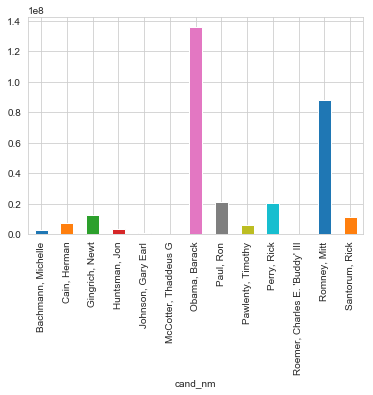

In [66]:
# Plot the total donation amounts
cand_amount.plot(kind="bar")

Now the comparison is very easy to see. As we saw berfore, clearly Obama is the front-runner in donation amounts, which makes sense, since he is not competeing with any other democratic nominees. How about we just compare Democrat versus Republican donations?

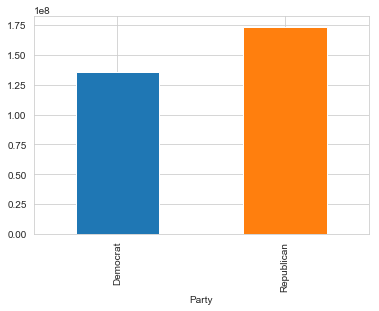

In [52]:
# Groupby party and then sum donations
donor_df.groupby("Party")["contb_receipt_amt"].sum().plot(kind="bar")

Looks like Obama couldn't compete against all the republicans, but he certainly has the advantage of their funding being splintered across multiple candidates.

Finally to start closing out the project, let's look at donations and who they came from (as far as occupation is concerned). We will start by grabing the occupation information from the dono_df DataFrame and then using pivot_table to make the index defined by the various occupations and then have the columns defined by the Party (Republican or Democrat). FInally we'll also pass an aggregation function in the pivot table, in this case a simple sum function will add up all the comntributions by anyone with the same profession.

In [53]:
# Use a pivot table to extract and organize the data by the donor occupation
occupation_df = donor_df.pivot_table("contb_receipt_amt",
                                    index="contbr_occupation",
                                    columns="Party",
                                    aggfunc="sum")

In [54]:
# Let's go ahead and check out the DataFrame
occupation_df.head()

Party,Democrat,Republican
contbr_occupation,,
MIXED-MEDIA ARTIST / STORYTELLER,100.0,NaN
AREA VICE PRESIDENT,250.0,NaN
RESEARCH ASSOCIATE,100.0,NaN
TEACHER,500.0,NaN
THERAPIST,3900.0,NaN


Great! Now let's see how big the DataFrame is.

In [55]:
# Check size
occupation_df.shape

(45067, 2)

Wow! This is probably far too large to display effectively with a small, static visualization. What we should do is have a cut-off for total contribution amounts. Afterall, small donations of 20 dollars by one type of occupation won't give us too much insight. So let's set our cut off at 1 million dollars.

In [57]:
# Set a cut off point at 1 million dollars of sum contributions
occupation_df = occupation_df[occupation_df.sum(1) > 1000000]

In [58]:
# Now let's check the size again!
occupation_df.shape

(31, 2)

Great! This looks much more manageable! Now let's visualize it.

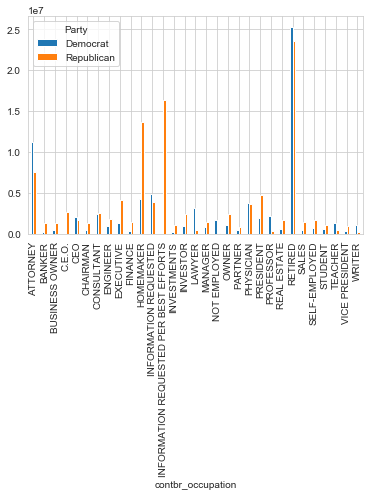

In [59]:
# Plot out with pandas
occupation_df.plot(kind="bar")

This is a bit hard to read, so let's use kind = 'barh' (horizontal) to set the ocucpation on the correct axis.

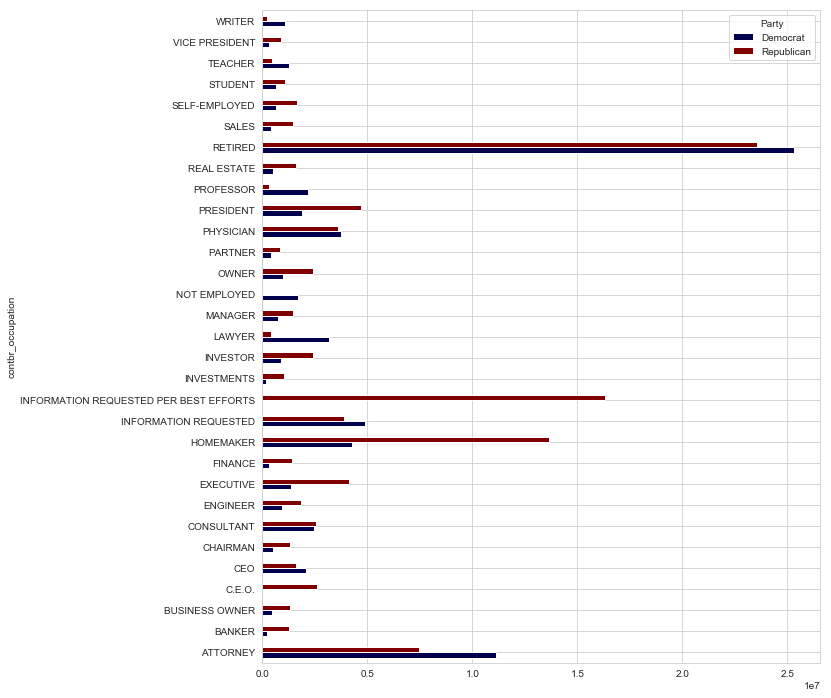

In [60]:
# Horizontal plot, using a convienently colored cmap
occupation_df.plot(kind="barh", figsize=(10,12), cmap="seismic")

Looks like there are some occupations that are either mislabeled or aren't really occupations. Let's get rid of: Information Requested occupations and let's combine CEO and C.E.O.

In [61]:
# Drop the unavailble occupations
occupation_df.drop(['INFORMATION REQUESTED PER BEST EFFORTS','INFORMATION REQUESTED'],axis=0,inplace=True)

Now let's combine the CEO and C.E.O rows.

In [62]:
# Set new CEO row as sum of the current two
occupation_df.loc["CEO"] = occupation_df.loc["CEO"] + occupation_df.loc["C.E.O."]
# Drop C.E.O
occupation_df.drop("C.E.O.", inplace=True)

Now let's repeat the same plot!

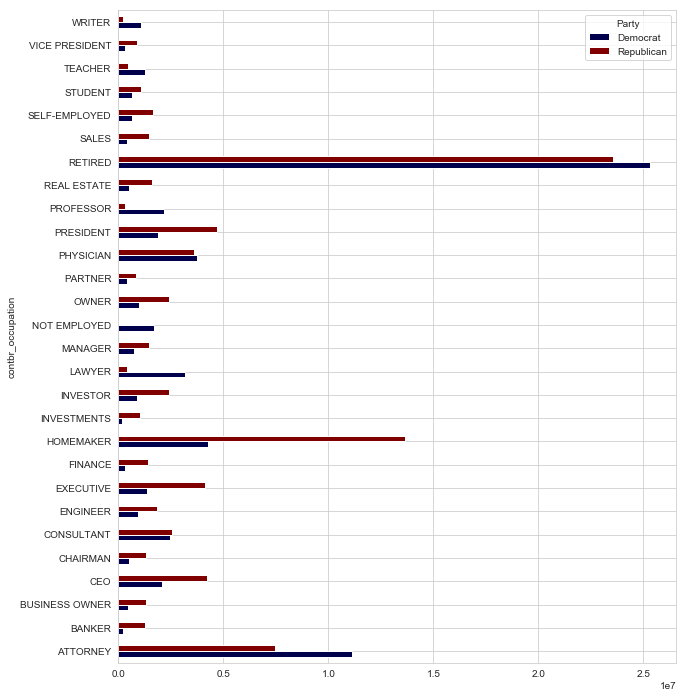

In [64]:
# Repeat the previous plot
occupation_df.plot(kind="barh", figsize=(10,12), cmap="seismic")

Awesome! Looks like CEOs are a little more conservative leaning, this may be due to the  tax philosphies of each party during the election.

### Great Job!
There's still so much to discover in these rich datasets! Come up with your own political questions you want answered! Or just play around with different methods of visualizing the data!

For more on general data analysis of politics, I highly suggest the [538](http://fivethirtyeight.com/politics/) website!

Again, great job on getting through the course this far! Go ahead and search the web for more data to discover!